In [1]:
import os
import librosa
import IPython.display as ipd
import matplotlib.pyplot as plt
import numpy as np
from scipy.io import wavfile
import warnings
warnings.filterwarnings("ignore")

In [2]:
! pip install kaggle

In [3]:
! mkdir ~/.kaggle

In [4]:
! cp kaggle.json ~/.kaggle/

In [5]:
! chmod 600 ~/.kaggle/kaggle.json

In [6]:
! kaggle competitions download tensorflow-speech-recognition-challenge

100% 3.49G/3.50G [02:49<00:00, 106MB/s]
100% 3.50G/3.50G [02:49<00:00, 22.2MB/s]


In [7]:
! unzip tensorflow-speech-recognition-challenge.zip

Archive:  tensorflow-speech-recognition-challenge.zip
  inflating: link_to_gcp_credits_form.txt  
  inflating: sample_submission.7z    
  inflating: test.7z                 
  inflating: train.7z                


In [8]:
!apt-get install p7zip-full
!p7zip -d train.7z

Reading package lists... Done
Building dependency tree       
Reading state information... Done
p7zip-full is already the newest version (16.02+dfsg-6).
0 upgraded, 0 newly installed, 0 to remove and 39 not upgraded.

7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 1121103842 bytes (1070 MiB)

Extracting archive: train.7z
--
Path = train.7z
Type = 7z
Physical Size = 1121103842
Headers Size = 389133
Method = Delta LZMA2:24
Solid = +
Blocks = 2

  0%      0% 38 - train/audio/_background_noise_/doing_the_dishes.wav                                                               0% 40 - train/audio/_background_noise_/exercise_bike.wav

In [45]:
!p7zip -d test.7z


7-Zip (a) [64] 16.02 : Copyright (c) 1999-2016 Igor Pavlov : 2016-05-21
p7zip Version 16.02 (locale=en_US.UTF-8,Utf16=on,HugeFiles=on,64 bits,2 CPUs Intel(R) Xeon(R) CPU @ 2.20GHz (406F0),ASM,AES-NI)

Scanning the drive for archives:
  0M Scan         1 file, 2640679130 bytes (2519 MiB)

Extracting archive: test.7z
--
Path = test.7z
Type = 7z
Physical Size = 2640679130
Headers Size = 1345163
Method = Delta LZMA2:24
Solid = +
Blocks = 3

  0%      0% 116 - test/audio/clip_002c56d95.wav                                          0% 247 - test/audio/clip_0066c98f7.wav                                          0% 378 - test/audio/clip_009fa6856.wav                                          0% 509 - test/audio/clip_00e18ec20.wav

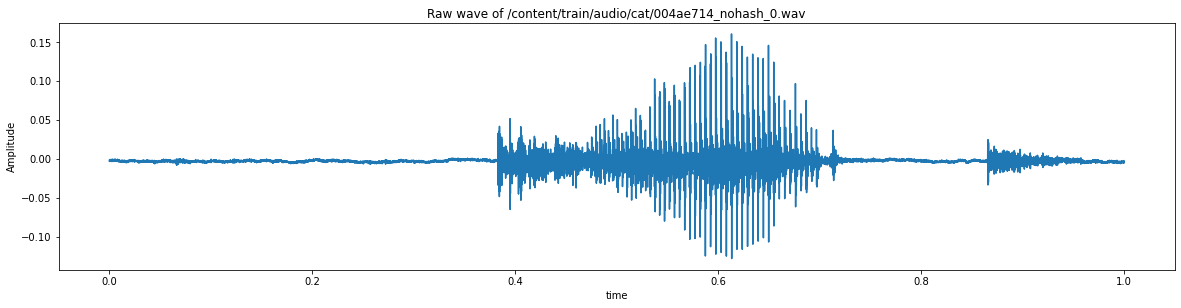

In [9]:
train_audio_path = '/content/train/audio/'
samples, sample_rate = librosa.load(train_audio_path+'cat/004ae714_nohash_0.wav', sr = 16000)
fig = plt.figure(figsize = (20, 10))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + '/content/train/audio/cat/004ae714_nohash_0.wav')
ax1.set_xlabel('time')
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0,sample_rate/len(samples), sample_rate), samples)

In [10]:
ipd.Audio(samples, rate=sample_rate)

In [11]:
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples, rate=8000)

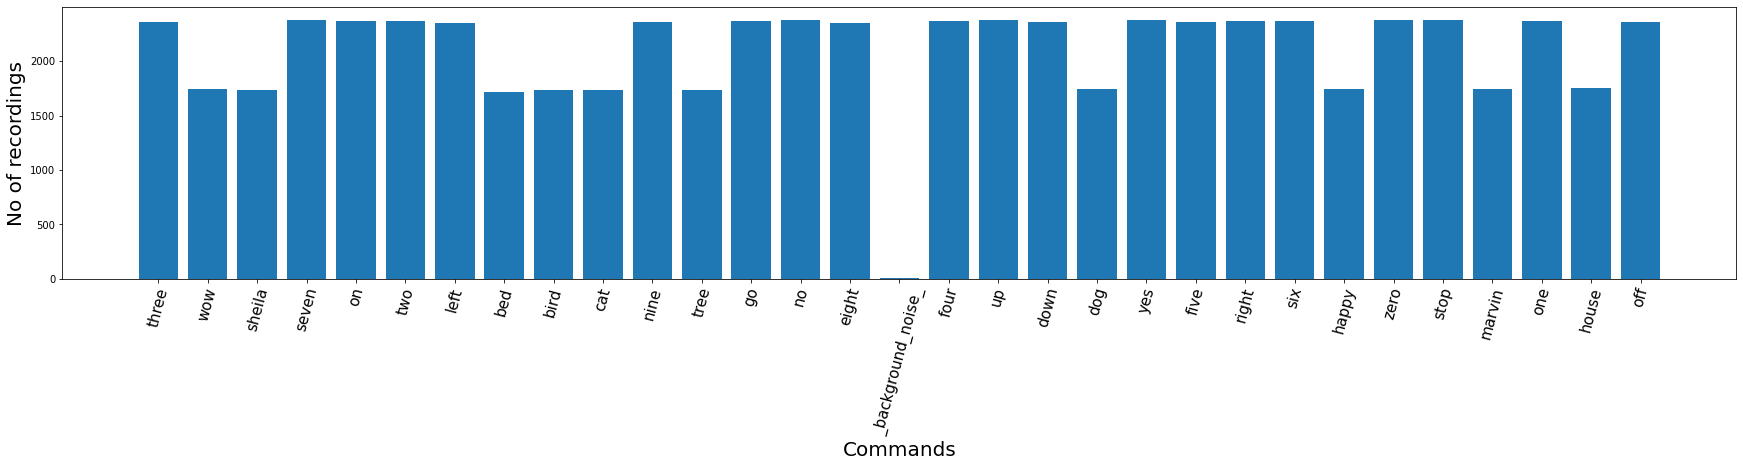

In [12]:
labels = os.listdir(train_audio_path)
#labels.remove('.DS_Store')

no_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/'+ label) if f.endswith('.wav')]
    no_of_recordings.append(len(waves))
    
plt.figure(figsize=(30,5))
index = np.arange(len(labels))
plt.bar(index, no_of_recordings)
plt.xlabel('Commands', fontsize=20)
plt.ylabel('No of recordings', fontsize=20)
plt.xticks(index, labels, fontsize=15, rotation=75)
plt.show()

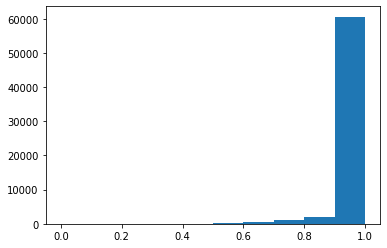

In [13]:
duration_of_recordings = []
for label in labels:
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        sample_rate, samples = wavfile.read(train_audio_path + '/' + label + '/' + wav)
        duration_of_recordings.append(float(len(samples)/sample_rate))

plt.hist(np.array(duration_of_recordings),range=[0,1]);

In [14]:
train_audio_path = '/content/train/audio/'

all_waves = []
all_labels = []
for label in labels:
    print(label)
    waves = [f for f in os.listdir(train_audio_path + '/' + label) if f.endswith('.wav')]
    for wav in waves:
        samples, sample_rate = librosa.load(train_audio_path + '/' + label + '/' + wav, sr = 16000)
        samples = librosa.resample(samples, sample_rate, 8000)
        if len(samples) == 8000:
            all_waves.append(samples)
            all_labels.append(label)


three
wow
sheila
seven
on
two
left
bed
bird
cat
nine
tree
go
no
eight
_background_noise_
four
up
down
dog
yes
five
right
six
happy
zero
stop
marvin
one
house
off


In [15]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(all_labels)
classes = list(le.classes_)

In [16]:
from keras.utils import np_utils
y = np_utils.to_categorical(y, num_classes = len(labels))

In [17]:
all_waves = np.array(all_waves).reshape(-1,8000,1)

In [18]:
from sklearn.model_selection import train_test_split
x_tr, x_val, y_tr, y_val = train_test_split(np.array(all_waves),np.array(y),stratify=y,test_size=0.2,random_state=777,shuffle=True)

In [19]:
from keras.layers import Dense, Dropout, Flatten, Conv1D, Input, MaxPooling1D
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import backend as K
K.clear_session()

inputs = Input(shape = (8000,1))

#First Layer
conv = Conv1D(8,13,padding='valid',activation='relu',strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Second Layer
conv = Conv1D(16,11,padding='valid',activation='relu',strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Third Layer
conv = Conv1D(32,9,padding='valid',activation='relu',strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Fourth Layer
conv = Conv1D(64,7,padding='valid',activation='relu',strides=1)(inputs)
conv = MaxPooling1D(3)(conv)
conv = Dropout(0.3)(conv)

#Flatten Layer
conv = Flatten()(conv)

#Dense Layer 1
conv = Dense(256,activation='relu')(conv)
conv = Dropout(0.3)(conv)

#Dense Layer 2
conv = Dense(128,activation='relu')(conv)
conv = Dropout(0.3)(conv)

outputs = Dense(len(labels),activation='softmax')(conv)

model = Model(inputs, outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 8000, 1)]         0         
                                                                 
 conv1d_3 (Conv1D)           (None, 7994, 64)          512       
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 2664, 64)         0         
 1D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 2664, 64)          0         
                                                                 
 flatten (Flatten)           (None, 170496)            0         
                                                                 
 dense (Dense)               (None, 256)               43647232  
                                                             

In [20]:
model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

In [21]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, min_delta=0.0001) 
mc = ModelCheckpoint('best_model.hdf5', monitor='val_acc', verbose=1, save_best_only=True, mode='max')

In [22]:
history=model.fit(x_tr, y_tr ,epochs=100, callbacks=[es,mc], batch_size=32, validation_data=(x_val,y_val))

Epoch 1/100
1457/1457 [==============================] - 841s 577ms/step - loss: 2.9828 - accuracy: 0.1395 - val_loss: 2.4622 - val_accuracy: 0.2906
Epoch 2/100
1457/1457 [==============================] - 866s 594ms/step - loss: 2.3899 - accuracy: 0.2894 - val_loss: 2.1023 - val_accuracy: 0.3898
Epoch 3/100
1457/1457 [==============================] - 859s 590ms/step - loss: 2.0664 - accuracy: 0.3740 - val_loss: 1.9073 - val_accuracy: 0.4406
Epoch 4/100
1457/1457 [==============================] - 861s 591ms/step - loss: 1.8266 - accuracy: 0.4435 - val_loss: 1.7912 - val_accuracy: 0.4733
Epoch 5/100
1457/1457 [==============================] - 862s 592ms/step - loss: 1.6607 - accuracy: 0.4872 - val_loss: 1.7579 - val_accuracy: 0.4826
Epoch 6/100
1457/1457 [==============================] - 858s 589ms/step - loss: 1.5304 - accuracy: 0.5269 - val_loss: 1.7379 - val_accuracy: 0.4885
Epoch 7/100
1457/1457 [==============================] - 853s 585ms/step - loss: 1.4207 - accuracy: 0.5625

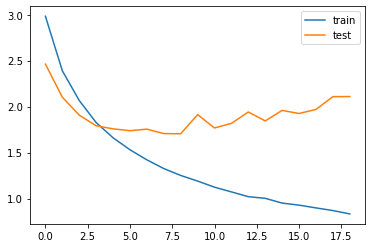

In [23]:
from matplotlib import pyplot
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

In [24]:
from keras.models import load_model
model = load_model('best_model.hdf5')

OSError: ignored

In [28]:
def predict(audio):
  prob = model.predict(audio.reshape(1,8000,1))
  index = np.argmax(prob[0])
  return classes[index]

In [33]:
import random
index = random.randint(0,len(x_val)-1)
samples = x_val[index].ravel()
print("Audio:",classes[np.argmax(y_val[index])])
ipd.Audio(samples, rate=8000)
print("Text:",predict(samples))

Audio: dog
Text: dog


In [43]:
!pip install sounddevice

In [41]:
!tar -xvf /content/pa_stable_v190700_20210406.tgz

portaudio/
portaudio/.editorconfig
portaudio/.gitattributes
portaudio/.github/
portaudio/.github/ISSUE_TEMPLATE/
portaudio/.github/ISSUE_TEMPLATE/bug_report.md
portaudio/.github/workflows/
portaudio/.github/workflows/MSBuild.yml
portaudio/.github/workflows/c-cpp.yml
portaudio/.gitignore
portaudio/CMakeLists.txt
portaudio/Doxyfile
portaudio/Doxyfile.developer
portaudio/LICENSE.txt
portaudio/Makefile.in
portaudio/README.configure.txt
portaudio/README.md
portaudio/SConstruct
portaudio/aclocal.m4
portaudio/bindings/
portaudio/bindings/cpp/
portaudio/bindings/cpp/AUTHORS
portaudio/bindings/cpp/COPYING
portaudio/bindings/cpp/ChangeLog
portaudio/bindings/cpp/INSTALL
portaudio/bindings/cpp/Makefile.am
portaudio/bindings/cpp/Makefile.in
portaudio/bindings/cpp/NEWS
portaudio/bindings/cpp/README
portaudio/bindings/cpp/SConscript
portaudio/bindings/cpp/aclocal.m4
portaudio/bindings/cpp/bin/
portaudio/bindings/cpp/bin/Makefile.am
portaudio/bindings/cpp/bin/Makefile.in
portaudio/bindings/cpp/build/


In [44]:
import sounddevice as sd
import soundfile as sf

samplerate = 16000  
duration = 1 # seconds
filename = 'yes.wav'
print("start")
mydata = sd.rec(int(samplerate * duration), samplerate=samplerate,
    channels=1, blocking=True)
print("end")
sd.wait()
sf.write(filename, mydata, samplerate)

OSError: ignored

In [56]:
filepath='/content/test/audio'

#reading the voice commands
samples, sample_rate = librosa.load(filepath + '/' + 'clip_0a67b927b.wav', sr = 16000)
samples = librosa.resample(samples, sample_rate, 8000)
ipd.Audio(samples,rate=8000)  

predict(samples)

'two'